1.IMPORT LIBRARIES

In [9]:
# pip install -r requirements.txt

In [2]:
# Core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import MSELoss
# Data handling
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader,TensorDataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics & utilities
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Progress & debugging
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import glob
import joblib

device = "mps" if torch.backends.mps.is_available() else "cpu"


2.DATA LOADER AND CREATE SEQUENCES

In [3]:
all_files = sorted(glob.glob("data/monthly_hourly_load_values_*.xlsx"))
df_list = [pd.read_excel(file) for file in all_files]
df = pd.concat(df_list, ignore_index=True)
df['DateUTC'] = pd.to_datetime(df['DateUTC'])
df.set_index('DateUTC', inplace=True)

# Training: 2019–2024, Testing: 2025
train_df_full = df[df.index.year < 2025]
test_df = df[df.index.year == 2025]

# Split validation from end of 2024 (10% of training)
val_ratio = 0.1
val_size = int(len(train_df_full) * val_ratio)
val_df = train_df_full.iloc[-val_size:]
train_df = train_df_full.iloc[:-val_size]

def create_sequences(data, seq_len=24, output_len=1):
    X, y = [], []
    for i in range(seq_len, len(data) - output_len + 1):
        X.append(data[i - seq_len:i])
        y.append(data[i:i + output_len].flatten())
    return np.array(X), np.array(y)



def prepare_multi_country_data_per_country_scaler(df, sequence_length=24, prediction_length=1, dataset_name="train/val"):
    """
    For each country, fit a StandardScaler, save it, and normalize values.
    """
    print(f"\n{'='*50}")
    print(f"PREPARING {dataset_name.upper()} WITH PER-COUNTRY SCALER")
    print(f"{'='*50}")

    df_clean = df.dropna(subset=['Value']).copy()
    df_clean = df_clean.sort_values(['CountryCode', 'DateUTC']).reset_index(drop=False)

    sequences = []
    targets = []
    countries = []
    timestamps = []

    for country in df_clean['CountryCode'].unique():
        country_data = df_clean[df_clean['CountryCode'] == country]
        scaler = StandardScaler()
        scaler.fit(country_data[['Value']])
        # Save scaler for later use
        # scaler_filename = f"scaler_{country}.pkl"
        # joblib.dump(scaler, scaler_filename)
        # Normalize values
        country_data['Value_normalized'] = scaler.transform(country_data[['Value']])
        values = country_data['Value_normalized'].values
        dates = country_data['DateUTC'].values
        X_seq, y_seq = create_sequences(values, seq_len=sequence_length, output_len=prediction_length)
        sequences.append(X_seq)
        targets.append(y_seq)
        countries.extend([country] * len(X_seq))
        timestamps.extend(dates[sequence_length:sequence_length+len(X_seq)])

    X = np.concatenate(sequences, axis=0) if sequences else np.array([])
    y = np.concatenate(targets, axis=0) if targets else np.array([])
    countries = np.array(countries)
    timestamps = np.array(timestamps)

    print(f"\nFinal dataset stats:")
    print(f"Total sequences: {len(X):,}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Normalized X range: [{X.min():.3f}, {X.max():.3f}]")
    print(f"Normalized y range: [{y.min():.3f}, {y.max():.3f}]")

    unique_countries, counts = np.unique(countries, return_counts=True)
    print(f"\nCountry distribution in sequences:")
    for country, count in zip(unique_countries, counts):
        print(f"  {country}: {count:,} sequences ({count/len(X)*100:.1f}%)")

    return X, y

X_train, y_train = prepare_multi_country_data_per_country_scaler(
    train_df, sequence_length=24, prediction_length=1
)

X_val, y_val= prepare_multi_country_data_per_country_scaler(
    val_df, sequence_length=24, prediction_length=1
)

X_test, y_test = prepare_multi_country_data_per_country_scaler(
    test_df, sequence_length=24, prediction_length=1,dataset_name="test"
)

print(f"All datasets normalized with the same scaler")
print(f"Train range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"Val range:   [{X_val.min():.3f}, {X_val.max():.3f}]")
print(f"Test range:  [{X_test.min():.3f}, {X_test.max():.3f}]")





PREPARING TRAIN/VAL WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 1,649,186
X shape: (1649186, 24)
y shape: (1649186, 1)
Normalized X range: [-6.300, 43.175]
Normalized y range: [-6.300, 43.175]

Country distribution in sequences:
  AL: 24,912 sequences (1.5%)
  AT: 52,584 sequences (3.2%)
  BA: 47,982 sequences (2.9%)
  BE: 52,584 sequences (3.2%)
  BG: 52,584 sequences (3.2%)
  CH: 52,583 sequences (3.2%)
  CY: 27,617 sequences (1.7%)
  CZ: 52,578 sequences (3.2%)
  DE: 52,584 sequences (3.2%)
  DK: 52,583 sequences (3.2%)
  EE: 52,577 sequences (3.2%)
  ES: 52,583 sequences (3.2%)
  FI: 52,584 sequences (3.2%)
  FR: 52,519 sequences (3.2%)
  GB: 36,816 sequences (2.2%)
  GE: 25,806 sequences (1.6%)
  GR: 43,911 sequences (2.7%)
  HR: 43,800 sequences (2.7%)
  HU: 43,798 sequences (2.7%)
  IE: 38,057 sequences (2.3%)
  IT: 43,800 sequences (2.7%)
  LT: 43,798 sequences (2.7%)
  LU: 43,800 sequences (2.7%)
  LV: 43,799 sequences (2.7%)
  MD: 34,307 sequences (2.1%)
 

3.MODEL

In [4]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout=0.1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))  # out shape: (batch_size, seq_length, hidden_size)
        out = self.fc(out[:, -1, :])     # Take the last time step
        return out
    
lstm_model = LSTM(input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout=0.1)
lstm_model.to(device)

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

LSTM-ATTENTION-CNN

4.TRAINING PIPELINE

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32, learning_rate=1e-4):
    """
    Simple PyTorch training function with tqdm progress bars
    """
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model.to(device)
    
    # Convert data to tensors
    if isinstance(X_train, np.ndarray):
        X_train = torch.FloatTensor(X_train)
    if isinstance(y_train, np.ndarray):
        y_train = torch.FloatTensor(y_train)
    if isinstance(X_val, np.ndarray):
        X_val = torch.FloatTensor(X_val)
    if isinstance(y_val, np.ndarray):
        y_val = torch.FloatTensor(y_val)
    
    # Create DataLoaders
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': []
    }
    
    print("Starting training...")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        # Create progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device), target.to(device)
            
            # Add channel dimension if needed (batch_size, seq_len) -> (batch_size, seq_len, 1)
            if len(data.shape) == 2:
                data = data.unsqueeze(-1)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.6f}',
                'Avg Loss': f'{train_loss/(batch_idx+1):.6f}'
            })
        
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
        
        with torch.no_grad():
            for data, target in val_pbar:
                data, target = data.to(device), target.to(device)
                if len(data.shape) == 2:
                    data = data.unsqueeze(-1)
                
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                
                # Update validation progress bar
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.6f}',
                    'Avg Loss': f'{val_loss/(len(val_pbar)+1):.6f}'
                })
        
        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        
        # Print epoch summary
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    print("Training completed!")
    return model,history

In [7]:
lstm_model, lstm_history = train_model(lstm_model, X_train, y_train, X_val, y_val, epochs=5)

Using device: mps
Starting training...


Epoch 1/5 [Val]: 100%|██████████| 5714/5714 [00:18<00:00, 314.03it/s, Loss=3.845993, Avg Loss=0.023176]


Epoch 1/5 - Train Loss: 0.031901, Val Loss: 0.023181


Epoch 2/5 [Val]: 100%|██████████| 5714/5714 [00:18<00:00, 313.54it/s, Loss=3.845207, Avg Loss=0.023809]


Epoch 2/5 - Train Loss: 0.027725, Val Loss: 0.023813


Epoch 3/5 [Val]: 100%|██████████| 5714/5714 [00:18<00:00, 310.58it/s, Loss=3.438511, Avg Loss=0.023292]


Epoch 3/5 - Train Loss: 0.027179, Val Loss: 0.023296


Epoch 4/5 [Val]: 100%|██████████| 5714/5714 [00:18<00:00, 315.03it/s, Loss=3.228509, Avg Loss=0.022628]


Epoch 4/5 - Train Loss: 0.026790, Val Loss: 0.022632


Epoch 5/5 [Val]: 100%|██████████| 5714/5714 [00:19<00:00, 299.33it/s, Loss=2.980243, Avg Loss=0.022117]


Epoch 5/5 - Train Loss: 0.026514, Val Loss: 0.022121
Training completed!


In [10]:
torch.save(lstm_model.state_dict(), 'model_state_dict_lstm.pth')

In [5]:
# Count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters in model_tft: {count_parameters(model):,}")

Number of trainable parameters in model_tft: 325,157


In [11]:
import matplotlib.pyplot as plt
def plot_partial_predictions(y_true, preds_dict, split_idx=0, group_title="Predictions", window_size=1000, start_idx=0):
    end_idx = start_idx + window_size
    plt.figure(figsize=(15, 5))
    plt.plot(range(start_idx, end_idx), y_true[start_idx:end_idx], label="True", linewidth=2)
    preds_to_plot = np.full_like(y_true[start_idx:end_idx], np.nan)
    preds_window = preds_dict[start_idx:end_idx]
    # Mask predictions before split_idx
    for i in range(window_size):
        global_idx = start_idx + i
        if global_idx >= split_idx and i < len(preds_window):
            preds_to_plot[i] = preds_window[i]
    plt.plot(range(start_idx, end_idx), preds_to_plot, label="Predicted", linewidth=2)
    if split_idx > start_idx and split_idx < end_idx:
        plt.axvline(split_idx, color='r', linestyle='--', label='Test Split')
    plt.title(group_title)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
def evaluate_model(y_true, y_pred, scaler=None):
    # Remove any extra dimensions but keep the prediction_length dimension
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    
    # Store original shapes for debugging
    original_shape_true = y_true.shape
    original_shape_pred = y_pred.shape
    
    print(f"Debug - y_true shape: {original_shape_true}, y_pred shape: {original_shape_pred}")
    
    if scaler:
        # For multi-step forecasting, we need to handle each time step separately
        # or flatten, transform, then reshape back
        if len(y_true.shape) > 1:
            # Multi-step forecasting - flatten, transform, then reshape back
            true_flat = y_true.reshape(-1, 1)
            pred_flat = y_pred.reshape(-1, 1)
            
            y_true = scaler.inverse_transform(true_flat).reshape(y_true.shape)
            y_pred = scaler.inverse_transform(pred_flat).reshape(y_pred.shape)
        else:
            # Single-step forecasting
            y_true = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
            y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Handle MAPE carefully to avoid division by zero
    # Use np.where to avoid division by very small numbers
    with np.errstate(divide='ignore', invalid='ignore'):
        ape = np.abs((y_true - y_pred) / np.where(np.abs(y_true) < 1e-8, 1e-8, y_true))
        mape = np.mean(ape) * 100
    
    print(f"Debug - After inverse - y_true range: [{y_true.min():.2f}, {y_true.max():.2f}]")
    print(f"Debug - After inverse - y_pred range: [{y_pred.min():.2f}, {y_pred.max():.2f}]")
    
    return round(rmse, 2), round(mae, 2), round(mape, 2), y_true, y_pred

def test_model(model, X_test, y_test, batch_size=32, scaler=None):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    if isinstance(X_test, np.ndarray):
        X_test = torch.FloatTensor(X_test)
    if isinstance(y_test, np.ndarray):
        y_test = torch.FloatTensor(y_test)
    
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Testing'):
            data, target = data.to(device), target.to(device)
            if len(data.shape) == 2:
                data = data.unsqueeze(-1)
            
            output = model(data)
            all_preds.append(output.cpu().numpy())
            all_targets.append(target.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    # Debug: Check shapes before evaluation
    print(f"Before evaluation - all_targets shape: {all_targets.shape}")
    print(f"Before evaluation - all_preds shape: {all_preds.shape}")
    print(f"Before evaluation - all_targets range: [{all_targets.min():.3f}, {all_targets.max():.3f}]")
    print(f"Before evaluation - all_preds range: [{all_preds.min():.3f}, {all_preds.max():.3f}]")
    
    rmse, mae, mape, y_true_inv, y_pred_inv = evaluate_model(all_targets, all_preds, scaler=scaler)
    
    print(f"Test RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%")
    
    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'y_true': y_true_inv,
        'y_pred': y_pred_inv
    }

In [12]:
def test_model_per_country(model, df, sequence_length=24, prediction_length=1, batch_size=32):
    """
    Test the model for each country using its own saved StandardScaler.
    """
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    model.eval()

    countries = df['CountryCode'].unique()
    results_dict = {}

    for country in countries:
        country_df = df[df['CountryCode'] == country].copy()
        scaler_path = f"scaler_{country}.pkl"
        try:
            scaler = joblib.load(scaler_path)
        except FileNotFoundError:
            print(f"Scaler for {country} not found. Skipping.")
            continue

        # Prepare sequences for this country
        X_test, y_test = prepare_multi_country_data_per_country_scaler(
            country_df, sequence_length=sequence_length, prediction_length=prediction_length, dataset_name="test"
        )
        if len(X_test) == 0:
            print(f"Skipping {country}: Not enough data for sequence_length={sequence_length}")
            continue

        # Convert to tensors
        if isinstance(X_test, np.ndarray):
            X_test = torch.FloatTensor(X_test)
        if isinstance(y_test, np.ndarray):
            y_test = torch.FloatTensor(y_test)

        test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        all_preds = []
        all_targets = []

        with torch.no_grad():
            for data, target in tqdm(test_loader, desc=f'Testing {country}'):
                data, target = data.to(device), target.to(device)
                if len(data.shape) == 2:
                    data = data.unsqueeze(-1)
                output = model(data)
                all_preds.append(output.cpu().numpy())
                all_targets.append(target.cpu().numpy())

        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)

        # Inverse transform using country scaler
        rmse, mae, mape, y_true_inv, y_pred_inv = evaluate_model(all_targets, all_preds, scaler=scaler)
        print(f"{country} - RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%")

        results_dict[country] = {
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'y_true': y_true_inv,
            'y_pred': y_pred_inv
        }

    return results_dict


PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,272
X shape: (4272, 24)
y shape: (4272, 1)
Normalized X range: [-1.645, 2.744]
Normalized y range: [-1.645, 2.744]

Country distribution in sequences:
  AL: 4,272 sequences (100.0%)


Testing AL: 100%|██████████| 134/134 [00:00<00:00, 307.95it/s]


Debug - y_true shape: (4272,), y_pred shape: (4272,)
Debug - After inverse - y_true range: [466.00, 1542.00]
Debug - After inverse - y_pred range: [436.44, 1574.84]
AL - RMSE: 33.52, MAE: 23.76, MAPE: 2.7899999618530273%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.986, 2.721]
Normalized y range: [-1.986, 2.721]

Country distribution in sequences:
  AT: 4,320 sequences (100.0%)


Testing AT: 100%|██████████| 135/135 [00:00<00:00, 425.92it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [4201.30, 10401.60]
Debug - After inverse - y_pred range: [4257.64, 10377.05]
AT - RMSE: 150.14, MAE: 117.12, MAPE: 1.7599999904632568%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,294
X shape: (4294, 24)
y shape: (4294, 1)
Normalized X range: [-2.295, 3.026]
Normalized y range: [-2.295, 3.026]

Country distribution in sequences:
  BA: 4,294 sequences (100.0%)


Testing BA: 100%|██████████| 135/135 [00:00<00:00, 248.93it/s]


Debug - y_true shape: (4294,), y_pred shape: (4294,)
Debug - After inverse - y_true range: [0.00, 2269.28]
Debug - After inverse - y_pred range: [-105.84, 2337.18]
BA - RMSE: 111.87, MAE: 63.99, MAPE: 23773620.0%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.205, 2.680]
Normalized y range: [-2.205, 2.680]

Country distribution in sequences:
  BE: 4,320 sequences (100.0%)


Testing BE: 100%|██████████| 135/135 [00:00<00:00, 452.35it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [6142.29, 13031.41]
Debug - After inverse - y_pred range: [6065.90, 13234.50]
BE - RMSE: 185.03, MAE: 142.43, MAPE: 1.559999942779541%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.738, 2.664]
Normalized y range: [-1.738, 2.664]

Country distribution in sequences:
  BG: 4,320 sequences (100.0%)


Testing BG: 100%|██████████| 135/135 [00:00<00:00, 425.47it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2533.35, 7337.07]
Debug - After inverse - y_pred range: [2488.48, 7348.05]
BG - RMSE: 89.54, MAE: 67.5, MAPE: 1.5499999523162842%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-3.817, 7.055]
Normalized y range: [-3.817, 7.055]

Country distribution in sequences:
  CH: 4,320 sequences (100.0%)


Testing CH: 100%|██████████| 135/135 [00:00<00:00, 497.04it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2373.54, 15866.32]
Debug - After inverse - y_pred range: [3306.95, 10167.47]
CH - RMSE: 456.47, MAE: 285.95, MAPE: 4.349999904632568%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,259
X shape: (4259, 24)
y shape: (4259, 1)
Normalized X range: [-1.925, 3.553]
Normalized y range: [-1.925, 3.553]

Country distribution in sequences:
  CY: 4,259 sequences (100.0%)


Testing CY: 100%|██████████| 134/134 [00:00<00:00, 241.03it/s]


Debug - y_true shape: (4259,), y_pred shape: (4259,)
Debug - After inverse - y_true range: [314.61, 1106.49]
Debug - After inverse - y_pred range: [315.09, 1057.82]
CY - RMSE: 21.93, MAE: 14.49, MAPE: 2.380000114440918%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.269, 2.602]
Normalized y range: [-2.269, 2.602]

Country distribution in sequences:
  CZ: 4,320 sequences (100.0%)


Testing CZ: 100%|██████████| 135/135 [00:00<00:00, 381.24it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [4316.86, 10793.66]
Debug - After inverse - y_pred range: [4214.35, 10799.28]
CZ - RMSE: 146.34, MAE: 113.8, MAPE: 1.6100000143051147%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.150, 2.380]
Normalized y range: [-2.150, 2.380]

Country distribution in sequences:
  DE: 4,320 sequences (100.0%)


Testing DE: 100%|██████████| 135/135 [00:00<00:00, 498.33it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [33628.78, 75361.36]
Debug - After inverse - y_pred range: [33812.95, 75163.19]
DE - RMSE: 893.6, MAE: 703.17, MAPE: 1.350000023841858%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,313
X shape: (4313, 24)
y shape: (4313, 1)
Normalized X range: [-2.703, 2.577]
Normalized y range: [-2.703, 2.577]

Country distribution in sequences:
  DK: 4,313 sequences (100.0%)


Testing DK: 100%|██████████| 135/135 [00:00<00:00, 497.15it/s]


Debug - y_true shape: (4313,), y_pred shape: (4313,)
Debug - After inverse - y_true range: [2454.92, 6251.81]
Debug - After inverse - y_pred range: [2550.59, 6157.48]
DK - RMSE: 126.62, MAE: 93.16, MAPE: 2.1600000858306885%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,319
X shape: (4319, 24)
y shape: (4319, 1)
Normalized X range: [-2.417, 2.915]
Normalized y range: [-2.417, 2.915]

Country distribution in sequences:
  EE: 4,319 sequences (100.0%)


Testing EE: 100%|██████████| 135/135 [00:00<00:00, 489.00it/s]


Debug - y_true shape: (4319,), y_pred shape: (4319,)
Debug - After inverse - y_true range: [482.00, 1437.90]
Debug - After inverse - y_pred range: [465.24, 1454.33]
EE - RMSE: 39.01, MAE: 27.49, MAPE: 3.1700000762939453%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-4.681, 2.803]
Normalized y range: [-4.681, 2.803]

Country distribution in sequences:
  ES: 4,320 sequences (100.0%)


Testing ES: 100%|██████████| 135/135 [00:00<00:00, 417.34it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [5599.00, 39696.00]
Debug - After inverse - y_pred range: [13164.96, 38265.92]
ES - RMSE: 841.29, MAE: 476.09, MAPE: 1.899999976158142%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.470, 2.416]
Normalized y range: [-2.470, 2.416]

Country distribution in sequences:
  FI: 4,320 sequences (100.0%)


Testing FI: 100%|██████████| 135/135 [00:00<00:00, 497.76it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [6602.23, 13272.25]
Debug - After inverse - y_pred range: [6663.08, 13229.59]
FI - RMSE: 148.95, MAE: 114.22, MAPE: 1.159999966621399%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,319
X shape: (4319, 24)
y shape: (4319, 1)
Normalized X range: [-1.960, 3.098]
Normalized y range: [-1.960, 3.098]

Country distribution in sequences:
  FR: 4,319 sequences (100.0%)


Testing FR: 100%|██████████| 135/135 [00:00<00:00, 490.61it/s]


Debug - y_true shape: (4319,), y_pred shape: (4319,)
Debug - After inverse - y_true range: [29309.96, 86645.88]
Debug - After inverse - y_pred range: [29569.05, 87654.91]
FR - RMSE: 1122.4, MAE: 846.67, MAPE: 1.7000000476837158%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 2,984
X shape: (2984, 24)
y shape: (2984, 1)
Normalized X range: [-2.057, 3.851]
Normalized y range: [-2.057, 3.851]

Country distribution in sequences:
  GB: 2,984 sequences (100.0%)


Testing GB: 100%|██████████| 94/94 [00:00<00:00, 342.28it/s]


Debug - y_true shape: (2984,), y_pred shape: (2984,)
Debug - After inverse - y_true range: [415.50, 1478.00]
Debug - After inverse - y_pred range: [427.64, 1374.55]
GB - RMSE: 33.09, MAE: 20.93, MAPE: 2.7300000190734863%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,158
X shape: (4158, 24)
y shape: (4158, 1)
Normalized X range: [-2.889, 2.371]
Normalized y range: [-2.889, 2.371]

Country distribution in sequences:
  GE: 4,158 sequences (100.0%)


Testing GE: 100%|██████████| 130/130 [00:00<00:00, 481.22it/s]


Debug - y_true shape: (4158,), y_pred shape: (4158,)
Debug - After inverse - y_true range: [906.09, 2296.83]
Debug - After inverse - y_pred range: [970.88, 2276.94]
GE - RMSE: 41.16, MAE: 27.77, MAPE: 1.7200000286102295%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.101, 3.515]
Normalized y range: [-2.101, 3.515]

Country distribution in sequences:
  GR: 4,320 sequences (100.0%)


Testing GR: 100%|██████████| 135/135 [00:00<00:00, 513.17it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [3207.00, 9422.00]
Debug - After inverse - y_pred range: [3263.17, 9253.24]
GR - RMSE: 123.54, MAE: 93.27, MAPE: 1.7000000476837158%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.265, 2.763]
Normalized y range: [-2.265, 2.763]

Country distribution in sequences:
  HR: 4,320 sequences (100.0%)


Testing HR: 100%|██████████| 135/135 [00:00<00:00, 513.08it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [1140.50, 3145.75]
Debug - After inverse - y_pred range: [1165.37, 3039.75]
HR - RMSE: 50.38, MAE: 38.58, MAPE: 1.909999966621399%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.999, 2.626]
Normalized y range: [-2.999, 2.626]

Country distribution in sequences:
  HU: 4,320 sequences (100.0%)


Testing HU: 100%|██████████| 135/135 [00:00<00:00, 510.80it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2211.19, 7394.76]
Debug - After inverse - y_pred range: [2441.45, 7462.21]
HU - RMSE: 121.14, MAE: 94.23, MAPE: 1.9500000476837158%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,301
X shape: (4301, 24)
y shape: (4301, 1)
Normalized X range: [-1.967, 3.398]
Normalized y range: [-1.967, 3.398]

Country distribution in sequences:
  IE: 4,301 sequences (100.0%)


Testing IE: 100%|██████████| 135/135 [00:00<00:00, 397.95it/s]


Debug - y_true shape: (4301,), y_pred shape: (4301,)
Debug - After inverse - y_true range: [2800.23, 5946.52]
Debug - After inverse - y_pred range: [2830.43, 5833.02]
IE - RMSE: 73.83, MAE: 55.3, MAPE: 1.399999976158142%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.020, 2.622]
Normalized y range: [-2.020, 2.622]

Country distribution in sequences:
  IT: 4,320 sequences (100.0%)


Testing IT: 100%|██████████| 135/135 [00:00<00:00, 493.69it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [17486.00, 49148.00]
Debug - After inverse - y_pred range: [17444.82, 48239.87]
IT - RMSE: 617.1, MAE: 473.12, MAPE: 1.5399999618530273%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.974, 3.022]
Normalized y range: [-1.974, 3.022]

Country distribution in sequences:
  LT: 4,320 sequences (100.0%)


Testing LT: 100%|██████████| 135/135 [00:00<00:00, 453.42it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [827.56, 2141.05]
Debug - After inverse - y_pred range: [837.56, 2180.45]
LT - RMSE: 45.13, MAE: 32.1, MAPE: 2.4100000858306885%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.152, 2.872]
Normalized y range: [-2.152, 2.872]

Country distribution in sequences:
  LU: 4,320 sequences (100.0%)


Testing LU: 100%|██████████| 135/135 [00:00<00:00, 522.62it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [347.27, 849.67]
Debug - After inverse - y_pred range: [345.82, 832.41]
LU - RMSE: 10.24, MAE: 7.47, MAPE: 1.350000023841858%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.210, 2.480]
Normalized y range: [-2.210, 2.480]

Country distribution in sequences:
  LV: 4,320 sequences (100.0%)


Testing LV: 100%|██████████| 135/135 [00:00<00:00, 521.01it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [477.16, 1195.94]
Debug - After inverse - y_pred range: [474.38, 1186.60]
LV - RMSE: 15.4, MAE: 11.59, MAPE: 1.4299999475479126%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,260
X shape: (4260, 24)
y shape: (4260, 1)
Normalized X range: [-3.674, 2.478]
Normalized y range: [-3.674, 2.478]

Country distribution in sequences:
  MD: 4,260 sequences (100.0%)


Testing MD: 100%|██████████| 134/134 [00:00<00:00, 356.71it/s]


Debug - y_true shape: (4260,), y_pred shape: (4260,)
Debug - After inverse - y_true range: [-0.00, 975.00]
Debug - After inverse - y_pred range: [148.33, 954.73]
MD - RMSE: 33.05, MAE: 20.48, MAPE: 2364083.0%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.143, 2.594]
Normalized y range: [-2.143, 2.594]

Country distribution in sequences:
  ME: 4,320 sequences (100.0%)


Testing ME: 100%|██████████| 135/135 [00:00<00:00, 490.15it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [139.07, 569.30]
Debug - After inverse - y_pred range: [141.61, 550.67]
ME - RMSE: 13.9, MAE: 10.27, MAPE: 3.259999990463257%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 3,312
X shape: (3312, 24)
y shape: (3312, 1)
Normalized X range: [-2.079, 1.915]
Normalized y range: [-2.079, 1.915]

Country distribution in sequences:
  MK: 3,312 sequences (100.0%)


Testing MK: 100%|██████████| 104/104 [00:00<00:00, 502.82it/s]


Debug - y_true shape: (3312,), y_pred shape: (3312,)
Debug - After inverse - y_true range: [-0.00, 1262.39]
Debug - After inverse - y_pred range: [-45.97, 1264.12]
MK - RMSE: 59.92, MAE: 38.04, MAPE: 8356227.0%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.772, 3.050]
Normalized y range: [-1.772, 3.050]

Country distribution in sequences:
  NL: 4,320 sequences (100.0%)


Testing NL: 100%|██████████| 135/135 [00:00<00:00, 496.27it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [9591.71, 19483.41]
Debug - After inverse - y_pred range: [9463.06, 19515.15]
NL - RMSE: 228.37, MAE: 167.24, MAPE: 1.25%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.956, 2.380]
Normalized y range: [-1.956, 2.380]

Country distribution in sequences:
  NO: 4,320 sequences (100.0%)


Testing NO: 100%|██████████| 135/135 [00:00<00:00, 508.76it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [10493.05, 23414.45]
Debug - After inverse - y_pred range: [10292.27, 23425.67]
NO - RMSE: 249.23, MAE: 190.8, MAPE: 1.190000057220459%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.471, 2.194]
Normalized y range: [-2.471, 2.194]

Country distribution in sequences:
  PL: 4,320 sequences (100.0%)


Testing PL: 100%|██████████| 135/135 [00:00<00:00, 506.26it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [10610.42, 24843.21]
Debug - After inverse - y_pred range: [10639.33, 25048.37]
PL - RMSE: 378.96, MAE: 280.6, MAPE: 1.5800000429153442%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-5.140, 2.810]
Normalized y range: [-5.140, 2.810]

Country distribution in sequences:
  PT: 4,320 sequences (100.0%)


Testing PT: 100%|██████████| 135/135 [00:00<00:00, 502.25it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [91.00, 9287.10]
Debug - After inverse - y_pred range: [2546.98, 9092.23]
PT - RMSE: 200.23, MAE: 115.42, MAPE: 6.289999961853027%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,319
X shape: (4319, 24)
y shape: (4319, 1)
Normalized X range: [-3.300, 2.539]
Normalized y range: [-3.300, 2.539]

Country distribution in sequences:
  RO: 4,319 sequences (100.0%)


Testing RO: 100%|██████████| 135/135 [00:00<00:00, 474.59it/s]


Debug - y_true shape: (4319,), y_pred shape: (4319,)
Debug - After inverse - y_true range: [2546.75, 8882.50]
Debug - After inverse - y_pred range: [2920.05, 8940.41]
RO - RMSE: 172.7, MAE: 114.82, MAPE: 1.9500000476837158%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.278, 2.385]
Normalized y range: [-2.278, 2.385]

Country distribution in sequences:
  RS: 4,320 sequences (100.0%)


Testing RS: 100%|██████████| 135/135 [00:00<00:00, 488.44it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2299.00, 5766.00]
Debug - After inverse - y_pred range: [2299.42, 5848.52]
RS - RMSE: 87.63, MAE: 66.79, MAPE: 1.7100000381469727%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.071, 2.473]
Normalized y range: [-2.071, 2.473]

Country distribution in sequences:
  SE: 4,320 sequences (100.0%)


Testing SE: 100%|██████████| 135/135 [00:00<00:00, 505.44it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [9203.00, 23187.00]
Debug - After inverse - y_pred range: [9284.21, 23216.43]
SE - RMSE: 362.1, MAE: 278.06, MAPE: 1.840000033378601%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,301
X shape: (4301, 24)
y shape: (4301, 1)
Normalized X range: [-3.010, 2.646]
Normalized y range: [-3.010, 2.646]

Country distribution in sequences:
  SI: 4,301 sequences (100.0%)


Testing SI: 100%|██████████| 135/135 [00:00<00:00, 488.06it/s]


Debug - y_true shape: (4301,), y_pred shape: (4301,)
Debug - After inverse - y_true range: [496.43, 2248.73]
Debug - After inverse - y_pred range: [548.78, 2220.37]
SI - RMSE: 55.16, MAE: 40.98, MAPE: 2.9800000190734863%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,318
X shape: (4318, 24)
y shape: (4318, 1)
Normalized X range: [-2.258, 2.545]
Normalized y range: [-2.258, 2.545]

Country distribution in sequences:
  SK: 4,318 sequences (100.0%)


Testing SK: 100%|██████████| 135/135 [00:00<00:00, 505.84it/s]


Debug - y_true shape: (4318,), y_pred shape: (4318,)
Debug - After inverse - y_true range: [1952.00, 4157.00]
Debug - After inverse - y_pred range: [1966.80, 4228.55]
SK - RMSE: 68.01, MAE: 50.49, MAPE: 1.6799999475479126%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.846, 2.403]
Normalized y range: [-1.846, 2.403]

Country distribution in sequences:
  XK: 4,320 sequences (100.0%)


Testing XK: 100%|██████████| 135/135 [00:00<00:00, 507.34it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [311.43, 1418.44]
Debug - After inverse - y_pred range: [303.97, 1399.73]
XK - RMSE: 28.15, MAE: 21.04, MAPE: 2.9200000762939453%


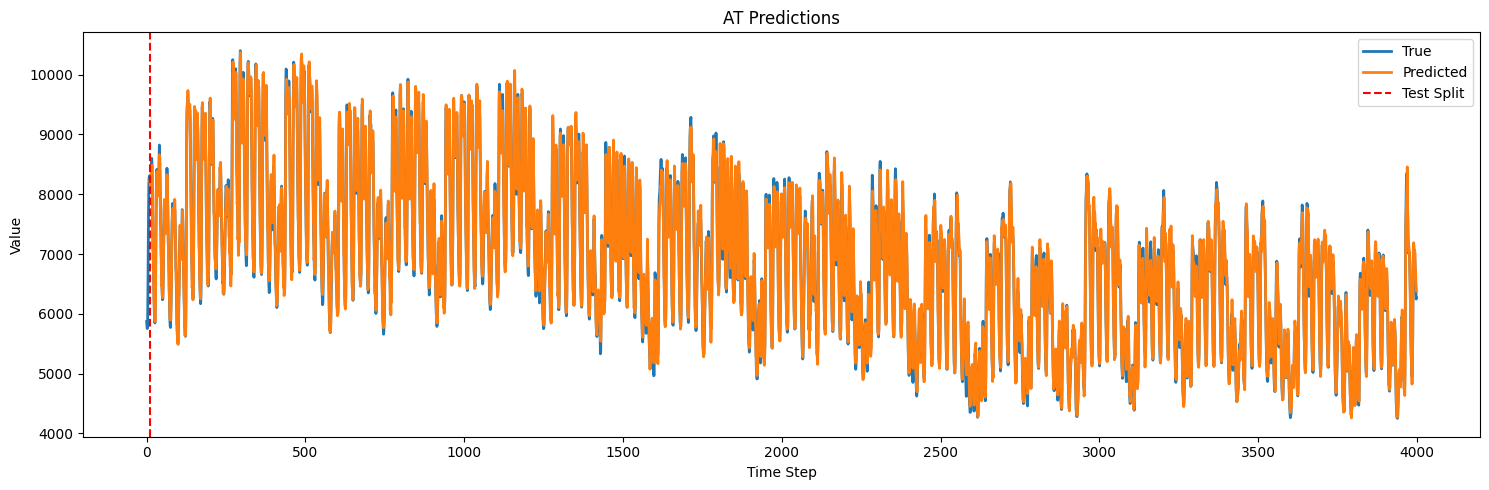

In [15]:
result = test_model_per_country(model=lstm_model, df=test_df, sequence_length=24, prediction_length=1)
plot_partial_predictions(
    y_true=result['AT']['y_true'],
    preds_dict=result['AT']['y_pred'],
    split_idx=10,
    group_title="AT Predictions",
    window_size=4000,  # Use the full available length
    start_idx=0
)

In [24]:
# Print 5 countries with smallest MAPE from ressult
def print_top5_smallest_mape(results_dict):
    # Create a list of (country, mape) tuples
    mape_list = [(country, results_dict[country]['mape']) for country in results_dict]
    # Sort by MAPE ascending
    mape_list_sorted = sorted(mape_list, key=lambda x: x[1])
    # Print top 5
    print("Top 5 countries with smallest MAPE:")
    for country, mape in mape_list_sorted[:5]:
        print(f"{country}: MAPE = {mape}%")
        print(f"  RMSE = {results_dict[country]['rmse']}, MAE = {results_dict[country]['mae']}")

# Example usage:
print_top5_smallest_mape(ressult)

Top 5 countries with smallest MAPE:
FI: MAPE = 1.059999942779541%
  RMSE = 136.76, MAE = 103.98
NO: MAPE = 1.0700000524520874%
  RMSE = 226.06, MAE = 172.02
NL: MAPE = 1.1100000143051147%
  RMSE = 204.68, MAE = 148.25
DE: MAPE = 1.1200000047683716%
  RMSE = 761.82, MAE = 592.28
LU: MAPE = 1.190000057220459%
  RMSE = 9.17, MAE = 6.62


In [ ]:
df_test_multi = test_df[test_df['CountryCode'].isin(['AT'])].copy()
df_test_multi['multistep']

In [16]:
# Calculate average metrics excluding countries with MAPE > 10%
def print_average_metrics_exclude_high_mape(results_dict, mape_threshold=10):
    filtered = [v for v in results_dict.values() if v['mape'] <= mape_threshold]
    if not filtered:
        print("No countries with MAPE below threshold.")
        return
    avg_rmse = np.mean([v['rmse'] for v in filtered])
    avg_mae = np.mean([v['mae'] for v in filtered])
    avg_mape = np.mean([v['mape'] for v in filtered])
    print(f"Average metrics for countries with MAPE ≤ {mape_threshold}%:")
    print(f"  RMSE: {avg_rmse:.2f}")
    print(f"  MAE:  {avg_mae:.2f}")
    print(f"  MAPE: {avg_mape:.2f}%")

# Example usage:
print_average_metrics_exclude_high_mape(result, mape_threshold=10)

Average metrics for countries with MAPE ≤ 10%:
  RMSE: 212.66
  MAE:  153.43
  MAPE: 2.12%


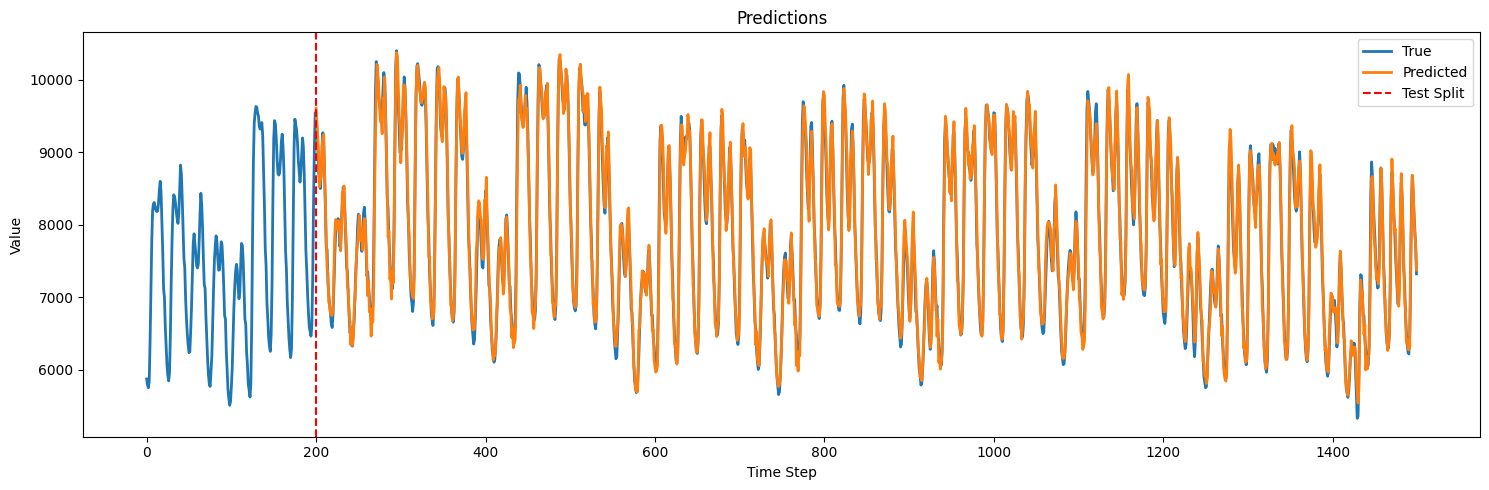

In [17]:
plot_partial_predictions(
    y_true=result['AT']['y_true'],
    preds_dict=result['AT']['y_pred'],
    split_idx=200,
    group_title="Predictions",
    window_size=1500, 
    start_idx=0
)